# PyTorch - homework TF 3: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1002949"
student_name="Hong Pengfei"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Hong Pengfei, number: 1002949


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()
lr = 0.0001
bs = 4
b1, b2 = 0.5, 0.999
latent_dim = 10
label_emb_dim = 10
channels = 3
# img_shape = (3, 224, 224)
n_epochs = 200

nz=latent_dim
ngf=ndf=128

nc=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.rcParams["figure.figsize"] = (15, 60)

 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5%20-%20ResNet.ipynb and the previously mentioned link. 



In [2]:
# load images and normalize + augment data
data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(128),
#         torchvision.transforms.ColorJitter(0.1),
#         torchvision.transforms.RandomHorizontalFlip(0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_dir = 'hymenoptera_data'

ds_trn, ds_tst = [datasets.ImageFolder(os.path.join(data_dir, x), data_transform) for x in ['train', 'val']]
image_dataset = data.ConcatDataset([ds_trn, ds_tst])
dataloader = data.DataLoader(image_dataset, batch_size=bs, shuffle=True, num_workers=4)
class_names = ds_trn.classes

c) Show a few images from the dataset so we understand what we are working with. 

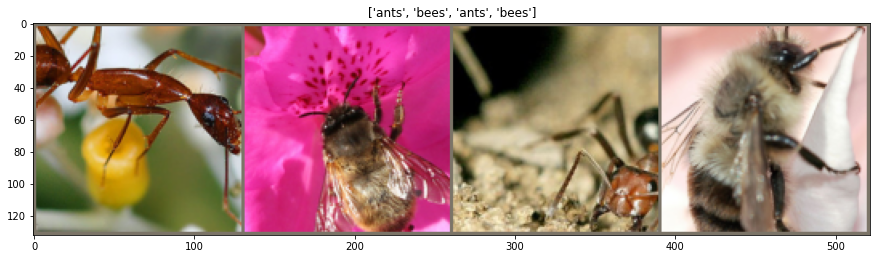

In [3]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [4]:
# your model here

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         self.label_emb = nn.Embedding(len(class_names), label_emb_dim)

#         def block(in_feat, out_feat, normalize=True):
#             layers = [nn.Linear(in_feat, out_feat)]
#             if normalize:
#                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(latent_dim + label_emb_dim, 128, normalize=False),
#             *block(128, 256),
#             *block(256, 512),
#             *block(512, 1024),
#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()
#         )

#     def forward(self, noise, labels):
#         # Concatenate label embedding and image to produce input
#         gen_input = torch.cat((self.label_emb(labels), noise), -1)
#         img = self.model(gen_input)
#         img = img.view(img.size(0), *img_shape)
#         return img

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.label_embedding = nn.Embedding(len(class_names),len(class_names))

#         self.model = nn.Sequential(
#             nn.Linear(len(class_names) + int(np.prod(img_shape)), 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 512),
#             nn.Dropout(0.4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 512),
#             nn.Dropout(0.4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 1),
#         )

#     def forward(self, img, labels):
#         # Concatenate label embedding and image to produce input
#         d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
#         validity = self.model(d_in)
#         return validity

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
#         self.ylabel=nn.Sequential(
#             nn.Linear(120,1000),
#             nn.ReLU(True)
#         )
        
        self.label_emb = nn.Embedding(len(class_names), label_emb_dim)
#         self.yz=nn.Sequential(
#             nn.Linear(latent_dim,200),
#             nn.ReLU(True)
#         )
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + label_emb_dim, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, z,y):
        
        #mapping noise and labe
#         z=self.yz(z)
        y=self.label_emb(y)
        
        #mapping concatenated input to the main generator network
        inp=torch.cat([z,y],1)
        inp=inp.view(-1, latent_dim + label_emb_dim, 1,1)
        output = self.main(inp)

        return output
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
            
#         self.ylabel=nn.Sequential(
#             nn.Linear(120,64*64*1),
#             nn.ReLU(True)
#         )
        
        self.label_emb = nn.Embedding(len(class_names), ndf*ndf*1)
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x,y):
        y=self.label_emb(y)
        y=y.view(-1,1,ndf,ndf)
        inp=torch.cat([x,y],1)
        output = self.main(inp)
        return output.view(-1, 1).squeeze(1)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

criterion = torch.nn.MSELoss()
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(b1, b2))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(b1, b2))



e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training.





In [5]:
# # train the network

# for epoch in range(n_epochs):
#     for i, (imgs, labels) in enumerate(dataloader):

#         batch_size = imgs.shape[0]

#         # Adversarial ground truths
#         valid = torch.ones(batch_size, 1).to(device)
#         fake = torch.zeros(batch_size, 1).to(device)

#         # Configure input
#         real_imgs = imgs.to(device)
#         labels = labels.to(device)

#         # -----------------
#         #  Train Generator
#         # -----------------

#         optimizer_G.zero_grad()

#         # Sample noise and labels as generator input
#         z = torch.FloatTensor((np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
#         gen_labels = torch.LongTensor(np.random.randint(0, len(class_names), batch_size)).to(device)

#         # Generate a batch of images
#         gen_imgs = generator(z, gen_labels)

#         # Loss measures generator's ability to fool the discriminator
#         validity = discriminator(gen_imgs, gen_labels)
#         g_loss = adversarial_loss(validity, valid)

#         g_loss.backward()
#         optimizer_G.step()

#         # ---------------------
#         #  Train Discriminator
#         # ---------------------

#         optimizer_D.zero_grad()

#         # Loss for real images
#         validity_real = discriminator(real_imgs, labels)
#         d_real_loss = adversarial_loss(validity_real, valid)

#         # Loss for fake images
#         validity_fake = discriminator(gen_imgs.detach(), gen_labels)
#         d_fake_loss = adversarial_loss(validity_fake, fake)

#         # Total discriminator loss
#         d_loss = (d_real_loss + d_fake_loss) / 2

#         d_loss.backward()
#         optimizer_D.step()

        
#         if epoch % 1 == 0 and i % np.inf == 1:
#             print(f"[{epoch} /  {n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
#             out = torchvision.utils.make_grid(gen_imgs.detach()[:4])
#             title = [class_names[i] for i in labels.detach().cpu().numpy()[:4]]
#             imshow(out, title)

[0 /  200] [D loss: 1.0] [G loss: 0.0]


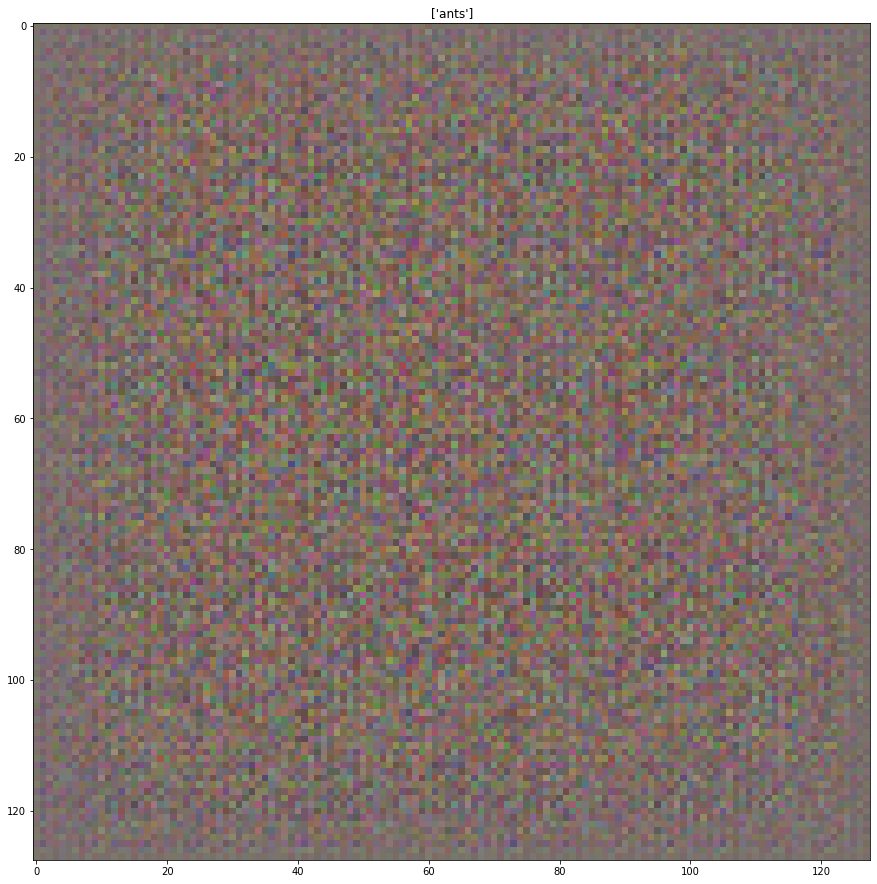

KeyboardInterrupt: 

In [6]:
# train the network

derror_epoch=[]
gerror_epoch=[]
real_label = 1
fake_label = 0
for epoch in range(n_epochs):
    derror_iter=0
    gerror_iter=0
    for i, data in enumerate(dataloader, 0):

        # DISCRIMINATOR 
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        breed= data[1].to(device)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_cpu, breed)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, device=device)
        fake = netG(noise,breed)
        label.fill_(fake_label)
        output = netD(fake.detach(),breed)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        derror_iter+=errD.item()
        optimizerD.step()
        
        # GENERATOR
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake,breed)
        errG = criterion(output, label)
        gerror_iter+=errG.item()
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
    if epoch % 10 == 0:
        print(f"[{epoch} /  {n_epochs}] [D loss: {errD.item()}] [G loss: {errG.item()}]")
        out = torchvision.utils.make_grid(fake.detach()[:4])
        title = [class_names[i] for i in breed.detach().cpu().numpy()[:4]]
        imshow(out, title)
            
            
    # accumulate error for each epoch
    derror_epoch.append(derror_iter)
    gerror_epoch.append(gerror_iter)

g) Does this model work well enough? What might be the reason for this? 

[your answer]

The model does not work very well, because GANs can have a number of common problems. Such as:

1. Vanishing Gradients
if the discriminator is really good, then it may provide little information for GANs to proceed. modified minimax loss we introduced in class can help to remedy the problem.

2. Mode collapse
if a generator produces an especially plausible output, the generator may learn to produce only that output. In fact, the generator is always trying to find the one output that seems most plausible to the discriminator. \\
Each iteration of generator over-optimizes for a particular discriminator, and the discriminator never manages to learn its way out of the trap. As a result the generators rotate through a small set of output types.

3. Failure to converge
As discriminator changes, the optimization problem is not static and keeps changing as well, therefore, it will highly likely that the generator will not able to converge to a plausible loss in the end.